In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,roc_auc_score,roc_curve,auc
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [2]:
# Import dataset
# The dataset was gotten from kaggle: https://www.kaggle.com/code/thomaskonstantin/bank-churn-data-exploration-and-churn-prediction/input
bank_churn = pd.read_csv("BankChurners.csv")
bank_churn.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [3]:
# The Client Number column and the Naive_Bayes Column are not useful for the model i am working on
# Therefore they need to be dropped
bank_churn = bank_churn.iloc[:,:-2]

In [4]:
bank_churn = bank_churn.drop(['CLIENTNUM'],axis=1)

In [5]:
bank_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [6]:
bank_churn.shape

(10127, 20)

In [7]:
print(bank_churn.columns)

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')


In [8]:
# Our Target Variable for the Model we are building is the Attrition Flag
# The Attrition Flag Shows us customers that are still with the bank and ones that have churned
# First we check the Unque Values in the Column
print(bank_churn['Attrition_Flag'].unique())

['Existing Customer' 'Attrited Customer']


In [9]:
# We have two Unique Values in the Attrition Flag Column
# The next thing to do is to convert the column to a binary variable
# 1 would represent Attrited Customer and 0 would represent Existing Customer
bank_churn["Attrition_Flag"] = bank_churn["Attrition_Flag"].map({'Attrited Customer':1,'Existing Customer':0})
bank_churn.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [10]:
# Now Checking for Emoty or null values in our dataset
bank_churn.isnull().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

- There are no null values in the dataset

C:\Users\User\AppData\Local\Temp\ipykernel_15468\3662549806.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Attrition_Flag",y=col,data=bank_churn,palette="pastel")
C:\Users\User\AppData\Local\Temp\ipykernel_15468\3662549806.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Attrition_Flag",y=col,data=bank_churn,palette="pastel")
C:\Users\User\AppData\Local\Temp\ipykernel_15468\3662549806.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Attrition_Flag",y=col,data=bank_churn,palette="pastel")
C:\Users\User\AppData\Local\Temp\i

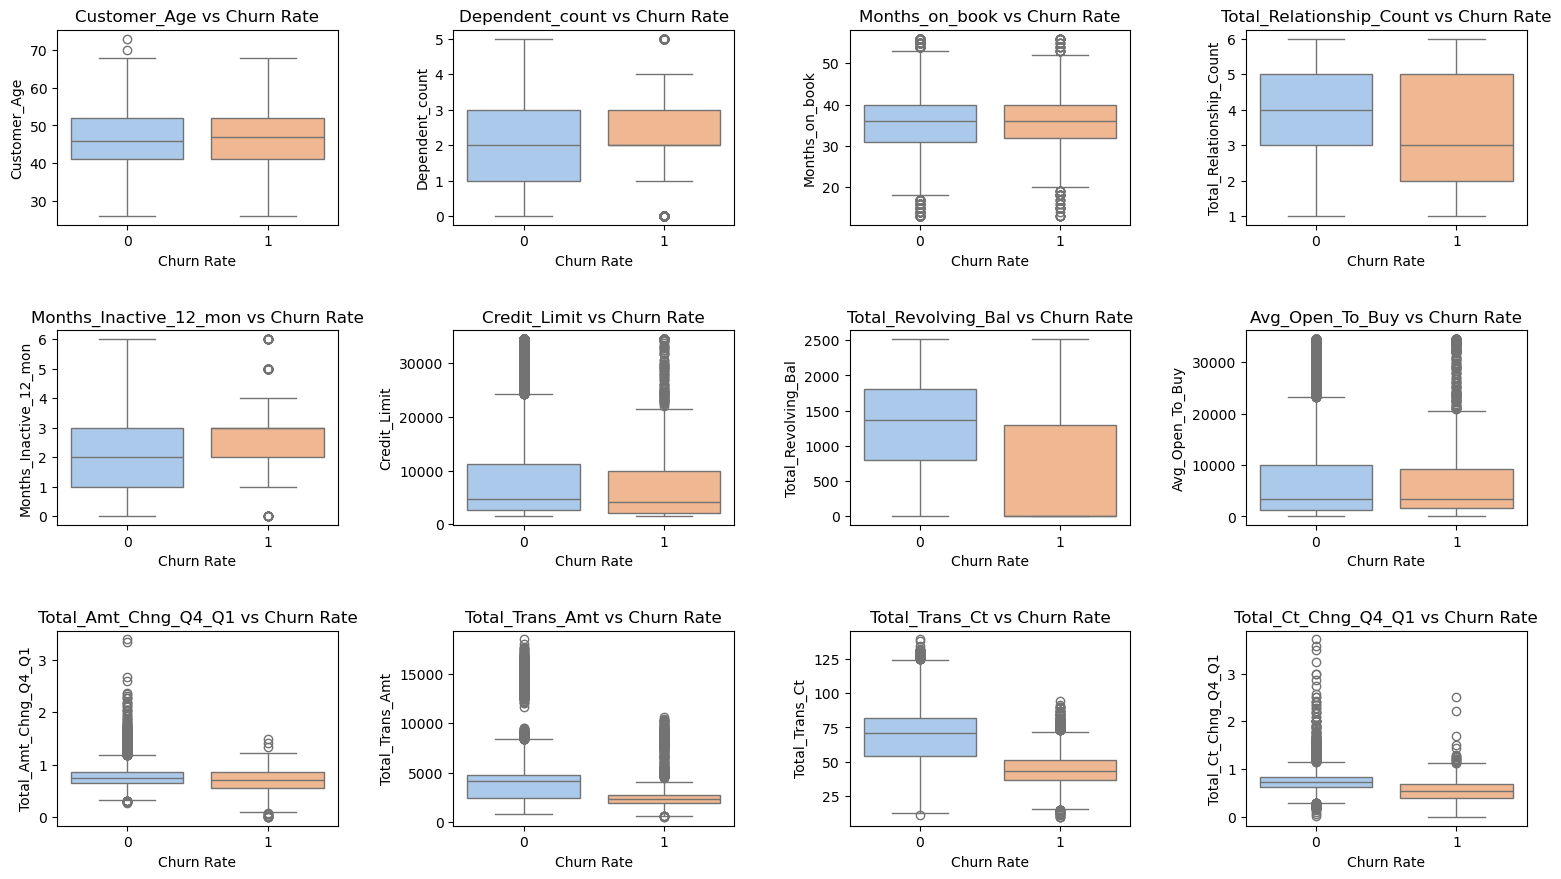

In [11]:
# Checking for outliers in Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1, Total_Trans_Amt,Total_Trans_Ct, Total_Ct_Chng_Q4_Q1
cols = ["Customer_Age","Dependent_count","Months_on_book","Total_Relationship_Count","Months_Inactive_12_mon",
        "Credit_Limit","Total_Revolving_Bal","Avg_Open_To_Buy","Total_Amt_Chng_Q4_Q1","Total_Trans_Amt","Total_Trans_Ct","Total_Ct_Chng_Q4_Q1"]
plt.figure(figsize=(16,12))
for idx,col in enumerate(cols,1):
    plt.subplot(4,4,idx)
    sns.boxplot(x="Attrition_Flag",y=col,data=bank_churn,palette="pastel")
    plt.title(f'{col} vs Churn Rate')
    plt.xlabel("Churn Rate")
    plt.ylabel(f'{col}')
plt.tight_layout(pad=3)
plt.show()
    

In [12]:
# We have a lot of outliers in some columns, this may affect the performance of our model
# But I also don't want to delete values from the dataset as they might still prove useful
# So as a compromise i decided to cap extreme values in the columns of the dataset
cols_to_cap = [
    'Credit_Limit', 'Avg_Open_To_Buy', 'Total_Trans_Amt', 'Total_Trans_Ct',
    'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1'
]

def cap_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    return df

capped_df = cap_outliers(bank_churn, cols_to_cap)

C:\Users\User\AppData\Local\Temp\ipykernel_15468\1130270023.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Attrition_Flag",y=col,data=bank_churn,palette="pastel")
C:\Users\User\AppData\Local\Temp\ipykernel_15468\1130270023.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Attrition_Flag",y=col,data=bank_churn,palette="pastel")
C:\Users\User\AppData\Local\Temp\ipykernel_15468\1130270023.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Attrition_Flag",y=col,data=bank_churn,palette="pastel")
C:\Users\User\AppData\Local\Temp\i

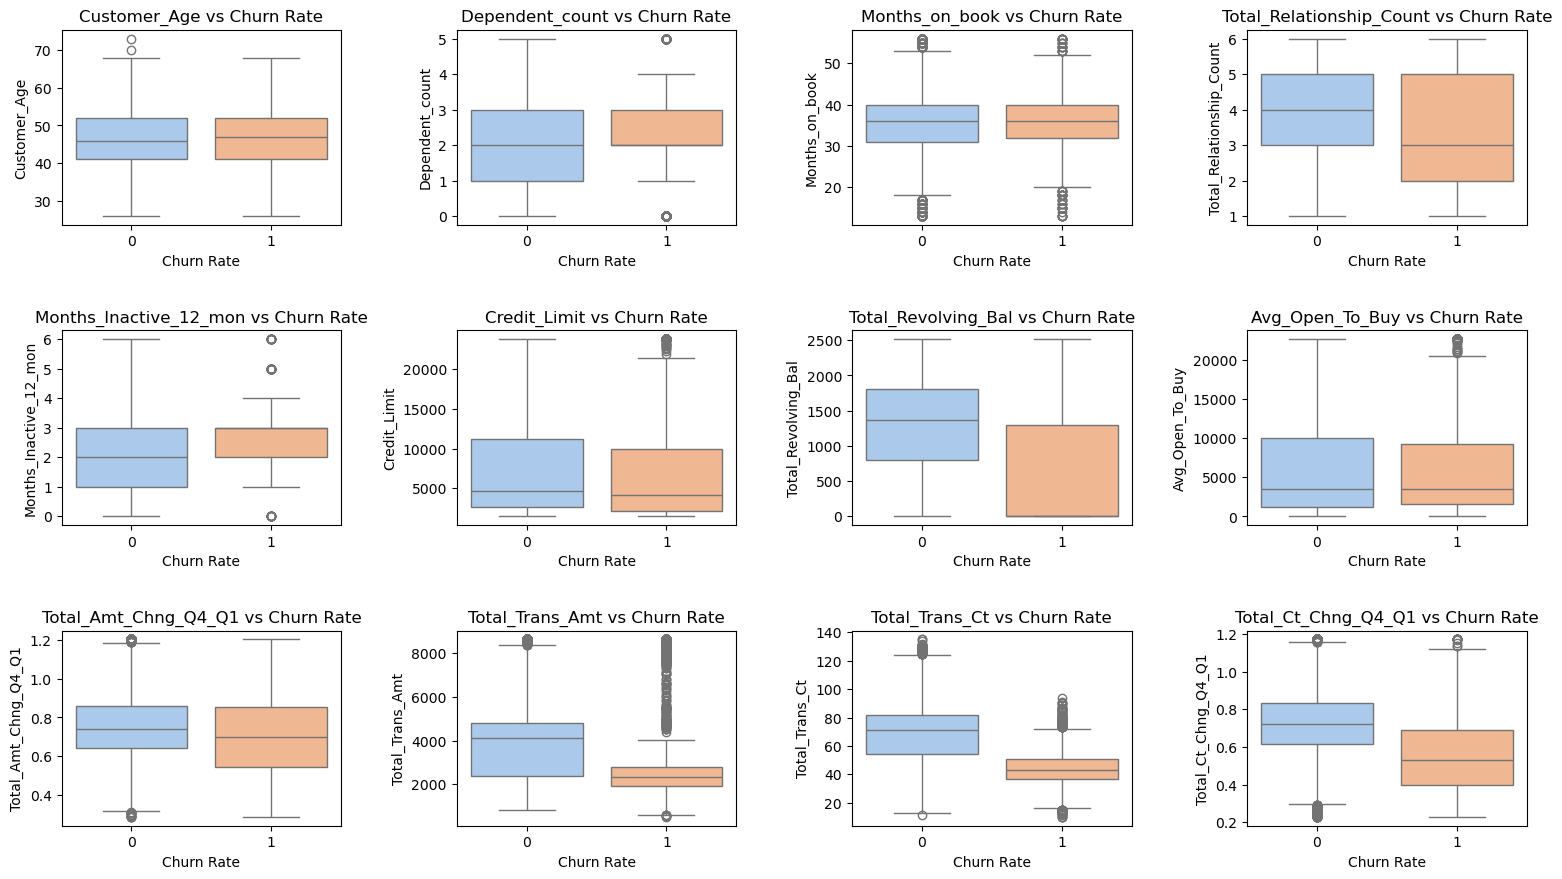

In [13]:
# Updated Boxplots after capping
cols = ["Customer_Age","Dependent_count","Months_on_book","Total_Relationship_Count","Months_Inactive_12_mon",
        "Credit_Limit","Total_Revolving_Bal","Avg_Open_To_Buy","Total_Amt_Chng_Q4_Q1","Total_Trans_Amt","Total_Trans_Ct","Total_Ct_Chng_Q4_Q1"]
plt.figure(figsize=(16,12))
for idx,col in enumerate(cols,1):
    plt.subplot(4,4,idx)
    sns.boxplot(x="Attrition_Flag",y=col,data=bank_churn,palette="pastel")
    plt.title(f'{col} vs Churn Rate')
    plt.xlabel("Churn Rate")
    plt.ylabel(f'{col}')
plt.tight_layout(pad=3)
plt.show()

# Exploratory Data Analysis

C:\Users\User\AppData\Local\Temp\ipykernel_15468\2513056525.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Attrition_Flag",data=bank_churn, palette="pastel")


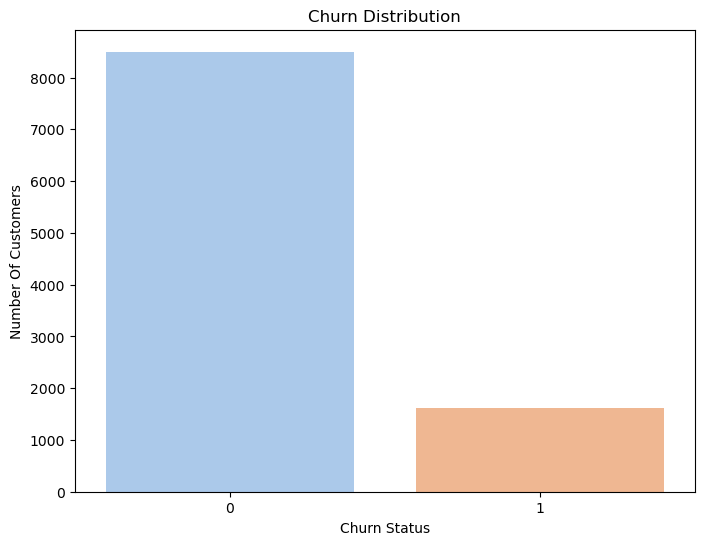

In [14]:
# Checking the population of Churned Customers and Existing Customers to know if the dataset is balanced
plt.figure(figsize=(8,6))
sns.countplot(x="Attrition_Flag",data=bank_churn, palette="pastel")
plt.title("Churn Distribution")
plt.xlabel("Churn Status")
plt.ylabel("Number Of Customers")
plt.show()

- The dataset is very balanced showing a much higher rate of customers retaining their status with the bank
- This can affect the performance of our model

C:\Users\User\AppData\Local\Temp\ipykernel_15468\48196158.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=bank_churn[bank_churn["Attrition_Flag"] == 1], x ="Customer_Age",label="Churn",shade=True,color="red")
C:\Users\User\AppData\Local\Temp\ipykernel_15468\48196158.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=bank_churn[bank_churn["Attrition_Flag"] == 0], x="Customer_Age",label="No Churn", shade=True,color="blue")


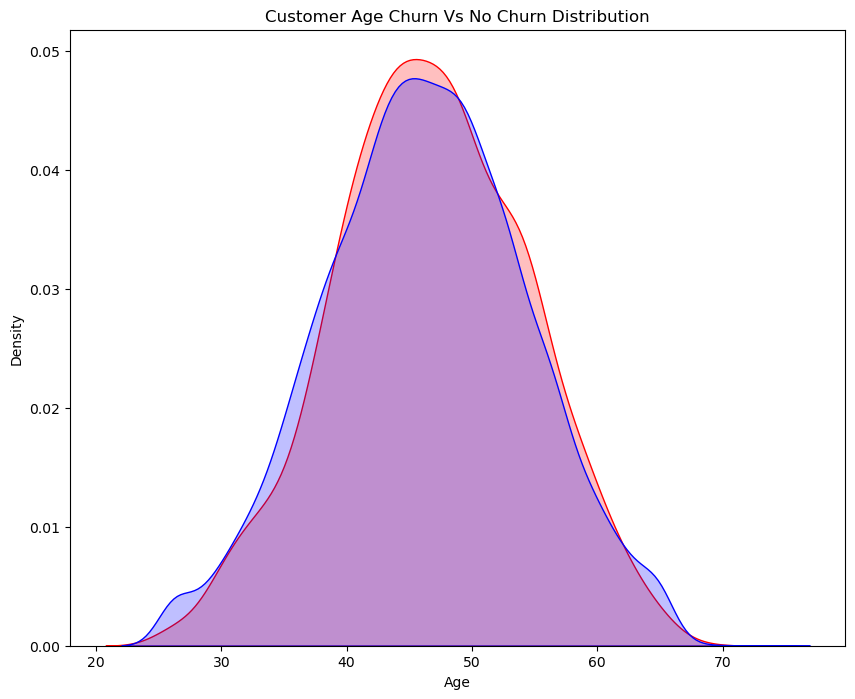

In [15]:
# Analyzing Customer_Age Vs Churn Rate
plt.figure(figsize=(10,8))
sns.kdeplot(data=bank_churn[bank_churn["Attrition_Flag"] == 1], x ="Customer_Age",label="Churn",shade=True,color="red")
sns.kdeplot(data=bank_churn[bank_churn["Attrition_Flag"] == 0], x="Customer_Age",label="No Churn", shade=True,color="blue")
plt.title("Customer Age Churn Vs No Churn Distribution")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

- Customers who churn(red) have a slightly higher density peak than customers who don't churn(blue) suggesting a higher proportion of churners around the age range 40 t0 50
- The density peaks for both occurs around the ages 40 to 50
- However age might not be a significant factor influencing churn in this dataset as the overall difference between the two distributions are minimal

C:\Users\User\AppData\Local\Temp\ipykernel_15468\4026296718.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Gender",data=bank_churn,palette = "pastel")


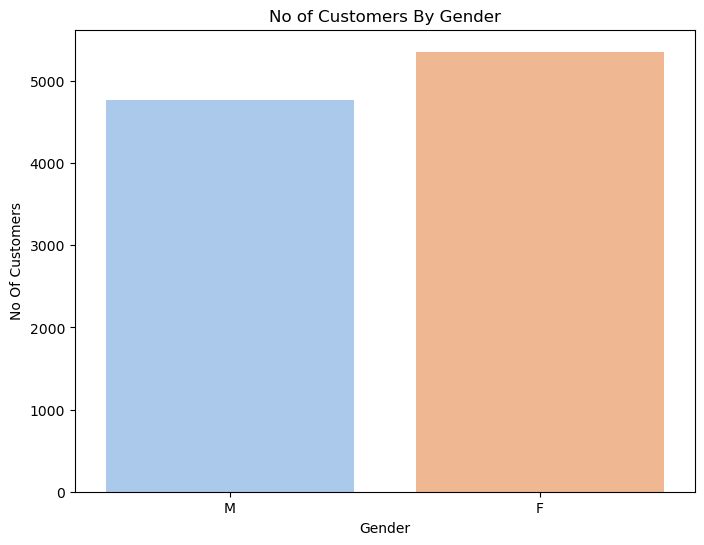

In [16]:
plt.figure(figsize=(8,6))
sns.countplot(x="Gender",data=bank_churn,palette = "pastel")
plt.title("No of Customers By Gender")
plt.xlabel("Gender")
plt.ylabel("No Of Customers")
plt.show()

In [17]:
bank_churn["Gender"].value_counts()

Gender
F    5358
M    4769
Name: count, dtype: int64

- There are more female customers than male customers in the bank

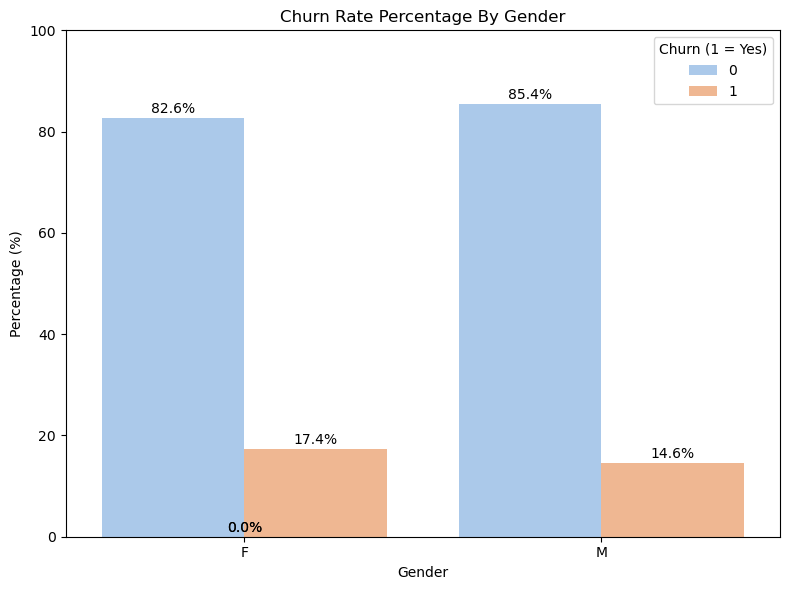

In [18]:
# Churn Rate Percentage By Gender

# Step 1: Group and calculate count
grouped = bank_churn.groupby(['Gender', 'Attrition_Flag']).size().reset_index(name='Count')

# Step 2: Calculate percentage per gender (fix using transform)
grouped['Percent'] = grouped['Count'] / grouped.groupby('Gender')['Count'].transform('sum') * 100

# Step 3: Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Gender', y='Percent', hue='Attrition_Flag', data=grouped, palette='pastel' )

# Step 4: Annotate with percentages
for p in ax.patches:
    percent = f'{p.get_height():.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 1, percent, ha='center', fontsize=10)

# Final styling
plt.title('Churn Rate Percentage By Gender')
plt.ylabel('Percentage (%)')
plt.xlabel('Gender')
plt.legend(title='Churn (1 = Yes)')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()



- Female Customers also have a higher churn rate than Male Customers
- However the difference is small
- So Gender might not be a key factor in determining customer churn rate

C:\Users\User\AppData\Local\Temp\ipykernel_15468\3630133746.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Marital_Status",data=bank_churn,palette = "pastel")


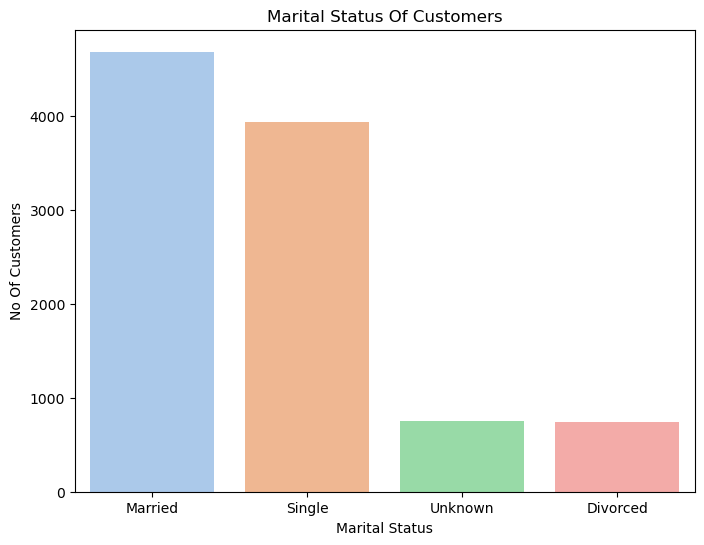

In [19]:
# Marital_Status 
plt.figure(figsize=(8,6))
sns.countplot(x="Marital_Status",data=bank_churn,palette = "pastel")
plt.title("Marital Status Of Customers")
plt.xlabel("Marital Status")
plt.ylabel("No Of Customers")
plt.show()

In [20]:
# Drop Unknown Values in Marital_status
bank_churn = bank_churn[bank_churn['Marital_Status'] != 'Unknown']

- The Bank has a higher population of Married Customers

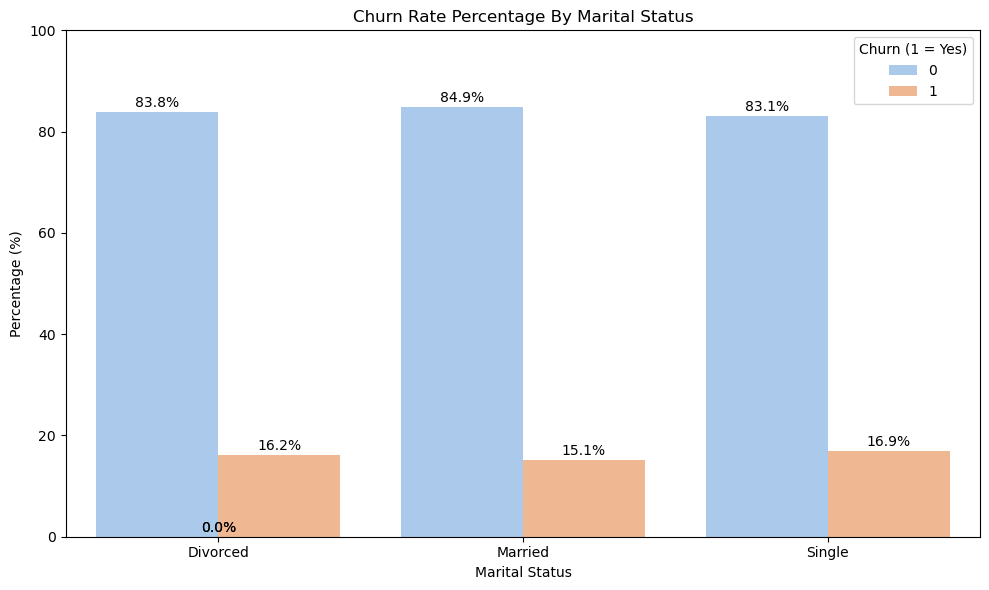

In [21]:
# Churn Rate Percentage By Marital Status
# Step 1: Group and count
grouped = bank_churn.groupby(['Marital_Status', 'Attrition_Flag']).size().reset_index(name='Count')

# Step 2: Calculate percentages within each marital group
grouped['Percent'] = grouped['Count'] / grouped.groupby('Marital_Status')['Count'].transform('sum') * 100

# Step 3: Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Marital_Status',
    y='Percent',
    hue='Attrition_Flag',
    data=grouped,
    palette='pastel',
    order=sorted(bank_churn['Marital_Status'].unique())  # Ensure consistent order
)

# Step 4: Annotate bars with %
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        fontsize=10
    )

# Final formatting
plt.title('Churn Rate Percentage By Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.legend(title='Churn (1 = Yes)')
plt.tight_layout()
plt.show()


- Singles are most likely to Churn(16.9%) with Divorcees being the second most likely to churn(16.2%)
- Married people are the least likely to churn
- Although the difference between the three categories is 1.8% 
- So Although Marital Status Might have a little influence in Churn Rate its role might not be majorly significant

C:\Users\User\AppData\Local\Temp\ipykernel_15468\122169934.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Education_Level",data=bank_churn,palette = "pastel")


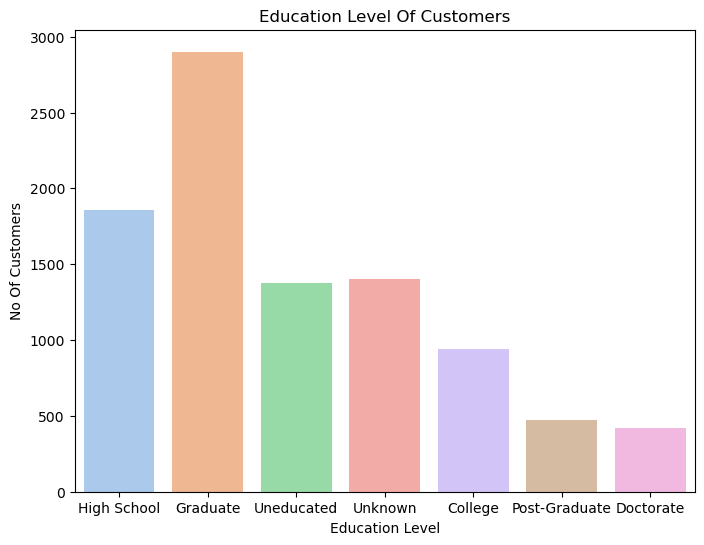

In [22]:
# Education_Level
plt.figure(figsize=(8,6))
sns.countplot(x="Education_Level",data=bank_churn,palette = "pastel")
plt.title("Education Level Of Customers")
plt.xlabel("Education Level")
plt.ylabel("No Of Customers")
plt.show()

- A Large Number Of Customers Are College Graduates
- Few Customers have Post-Graduate and Doctorate Degress

In [23]:
# Drop Unknown Values in Education_Level
bank_churn = bank_churn[bank_churn['Education_Level'] != 'Unknown']

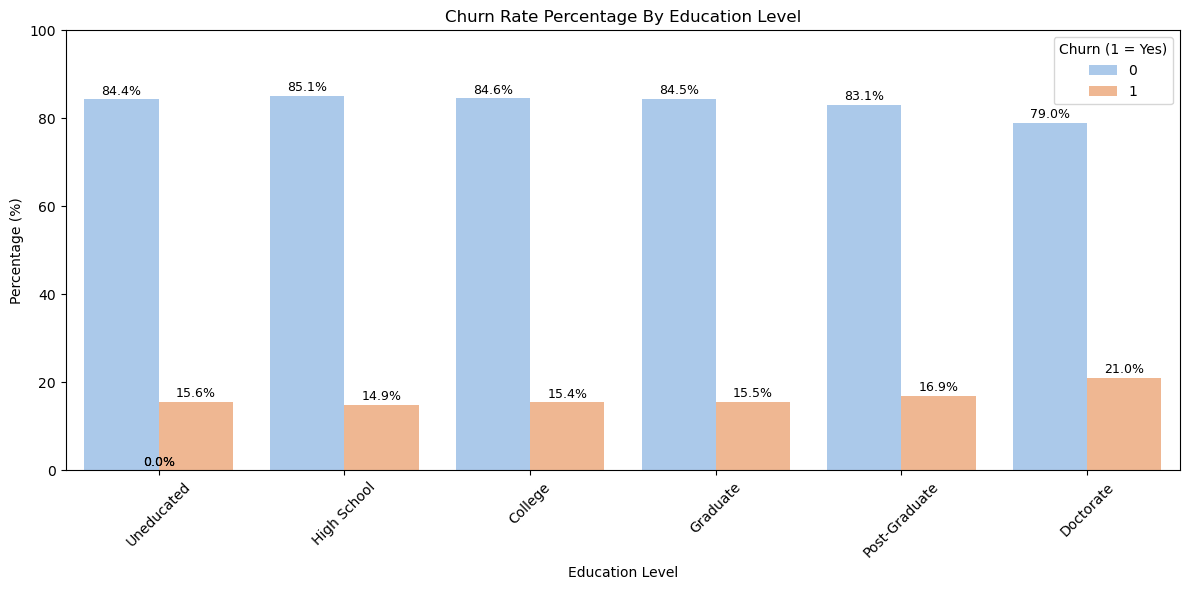

In [24]:
# Churn Rate Percentage By Education Level
# Step 1: Group and count
grouped = bank_churn.groupby(['Education_Level', 'Attrition_Flag']).size().reset_index(name='Count')

# Step 2: Calculate % within each education level
grouped['Percent'] = grouped['Count'] / grouped.groupby('Education_Level')['Count'].transform('sum') * 100

# Optional: Custom order (if needed)
edu_order = [
    'Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate'
]

# Step 3: Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='Education_Level',
    y='Percent',
    hue='Attrition_Flag',
    data=grouped,
    palette='pastel',
    order=edu_order  # Apply order to keep consistency
)

# Step 4: Annotate with percentages
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        fontsize=9
    )

# Final formatting
plt.title('Churn Rate Percentage By Education Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.legend(title='Churn (1 = Yes)')
plt.tight_layout()
plt.show()


- Customers with a higher level of education( Post-Graduate, Doctorate) are more likely to churn despite being fewer in size than other categories

C:\Users\User\AppData\Local\Temp\ipykernel_15468\3328410010.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Card_Category",data=bank_churn,palette = "pastel")


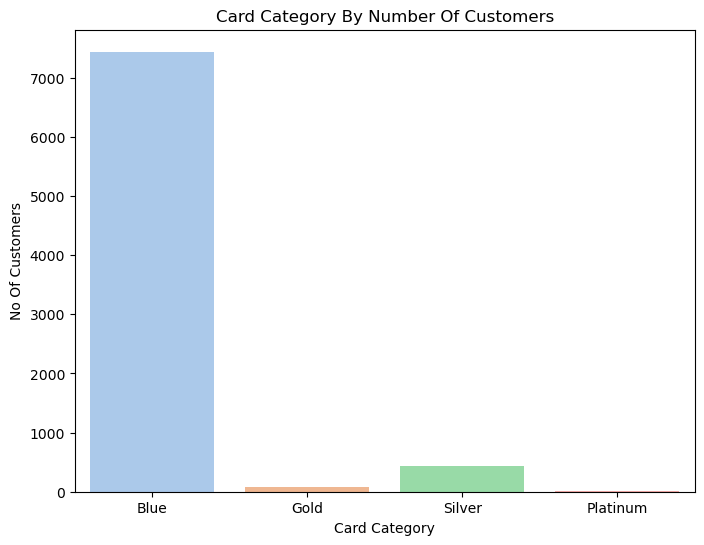

In [25]:
# Analyzing By Card Category
plt.figure(figsize=(8,6))
sns.countplot(x="Card_Category",data=bank_churn,palette = "pastel")
plt.title("Card Category By Number Of Customers")
plt.xlabel("Card Category")
plt.ylabel("No Of Customers")
plt.show()

- A Large chunk of Customers have the lower tier category cards Blue and Silver with Blue being the largest population by a wide gap
- Platinum and Gold category users are very low

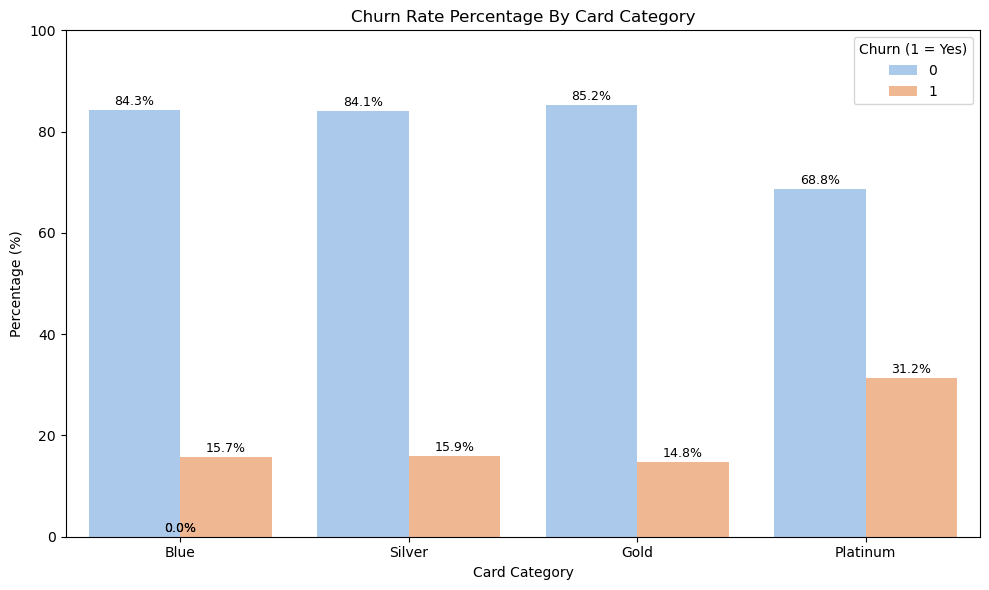

In [26]:
# Churn Rate Percentage By Card Category

# Step 1: Group and count
grouped = bank_churn.groupby(['Card_Category', 'Attrition_Flag']).size().reset_index(name='Count')

# Step 2: Calculate % within each card category
grouped['Percent'] = grouped['Count'] / grouped.groupby('Card_Category')['Count'].transform('sum') * 100

# Optional: Custom order based on your dataset
card_order = ['Blue', 'Silver', 'Gold', 'Platinum']

# Step 3: Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Card_Category',
    y='Percent',
    hue='Attrition_Flag',
    data=grouped,
    palette='pastel',
    order=card_order  # maintain category order
)

# Step 4: Annotate with percentages
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        fontsize=9
    )

# Final formatting
plt.title('Churn Rate Percentage By Card Category')
plt.xlabel('Card Category')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.legend(title='Churn (1 = Yes)')
plt.tight_layout()
plt.show()


- Higher tier cardholders (Gold,Platinum) have a higher churn rate than lower tier card holders( Silver and Blue)
- Silver cardholders are the least likely to churn with a churn rate of 15%
- Platinum Cardholders are most likely to churn with a churn rate of 25%

C:\Users\User\AppData\Local\Temp\ipykernel_15468\1151052170.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Income_Category",data=bank_churn,palette = "pastel")


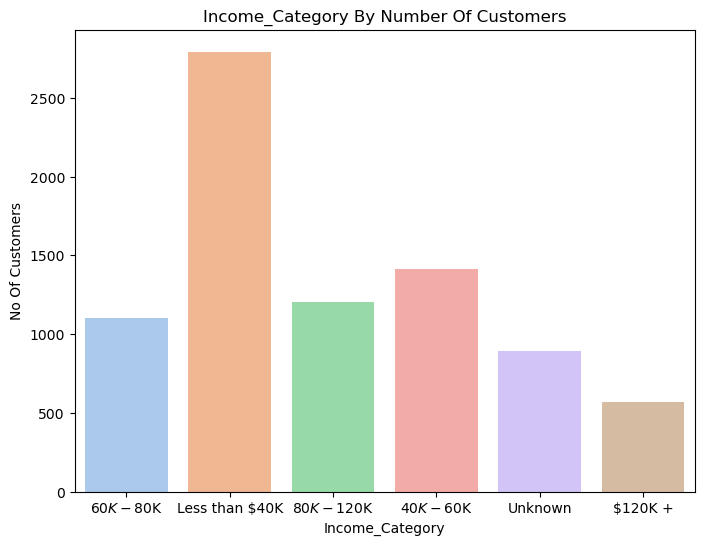

In [27]:
# Analyzing By Income Category
plt.figure(figsize=(8,6))
sns.countplot(x="Income_Category",data=bank_churn,palette = "pastel")
plt.title("Income_Category By Number Of Customers")
plt.xlabel("Income_Category")
plt.ylabel("No Of Customers")
plt.show()

- A dominant number of Customers earn less than $ 40K in a year

  
- The number of Customers earning $120K and above is minimal compared to other income categories

In [28]:
# Replacing Unknown in Income_Category with Modal Income Category
bank_churn['Income_Category'] = bank_churn['Income_Category'].replace({'Unknown': 'Less than $40K'})

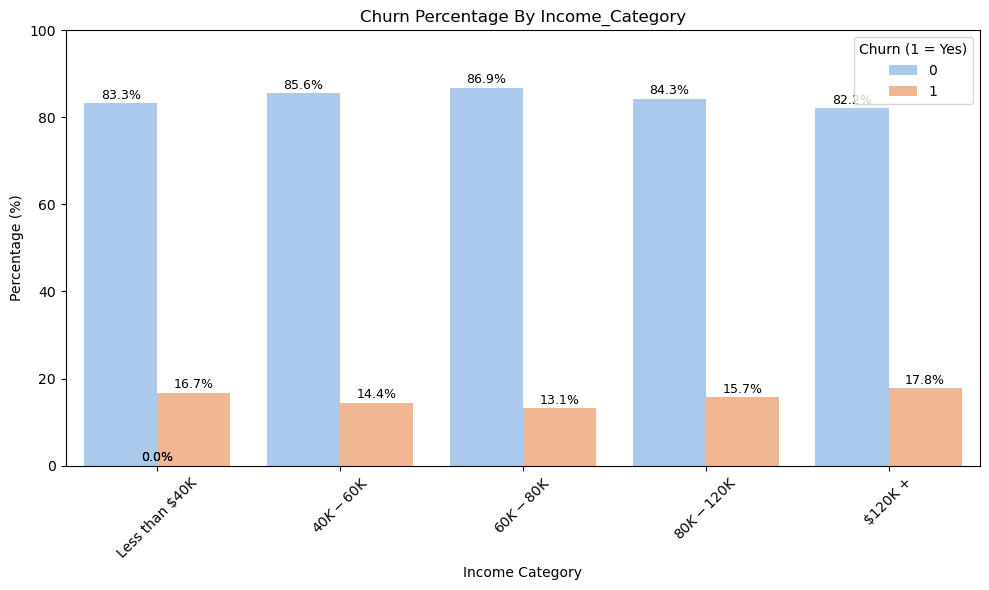

In [29]:
# Churn Percentage By Income_Category

# Step 1: Group and count
grouped = bank_churn.groupby(['Income_Category', 'Attrition_Flag']).size().reset_index(name='Count')

# Step 2: Calculate % within each income category
grouped['Percent'] = grouped['Count'] / grouped.groupby('Income_Category')['Count'].transform('sum') * 100

# Optional: Custom order for logical income progression
income_order = [
    'Less than $40K', '$40K - $60K', '$60K - $80K', 
    '$80K - $120K', '$120K +'
]

# Step 3: Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Income_Category',
    y='Percent',
    hue='Attrition_Flag',
    data=grouped,
    palette='pastel',
    order=income_order  # Ensure logical order of income levels
)

# Step 4: Annotate with percentages
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        fontsize=9
    )

# Final formatting
plt.title('Churn Percentage By Income_Category')
plt.xlabel('Income Category')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.legend(title='Churn (1 = Yes)')
plt.tight_layout()
plt.show()


- There is no consistent pattern or correlation between income level and churn rates

- Both the Lowest and Top income level have highest churnest rates

C:\Users\User\AppData\Local\Temp\ipykernel_15468\4096184314.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=bank_churn[bank_churn["Attrition_Flag"] == 1], x ="Credit_Limit",label="Churn",shade=True,color="red")
C:\Users\User\AppData\Local\Temp\ipykernel_15468\4096184314.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=bank_churn[bank_churn["Attrition_Flag"] == 0], x="Credit_Limit",label="No Churn", shade=True,color="blue")


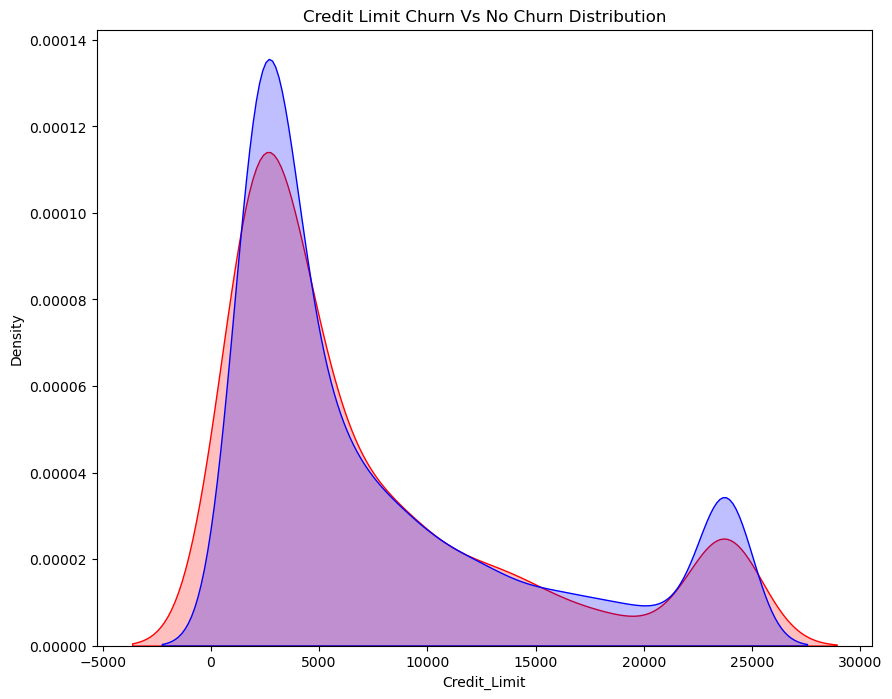

In [30]:
# Analyzing Credit Limit Vs Churn Rate
plt.figure(figsize=(10,8))
sns.kdeplot(data=bank_churn[bank_churn["Attrition_Flag"] == 1], x ="Credit_Limit",label="Churn",shade=True,color="red")
sns.kdeplot(data=bank_churn[bank_churn["Attrition_Flag"] == 0], x="Credit_Limit",label="No Churn", shade=True,color="blue")
plt.title("Credit Limit Churn Vs No Churn Distribution")
plt.xlabel("Credit_Limit")
plt.ylabel("Density")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_15468\3645019103.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=bank_churn[bank_churn["Attrition_Flag"] == 1], x ="Total_Trans_Amt",label="Churn",shade=True,color="red")
C:\Users\User\AppData\Local\Temp\ipykernel_15468\3645019103.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=bank_churn[bank_churn["Attrition_Flag"] == 0], x="Total_Trans_Amt",label="No Churn", shade=True,color="blue")


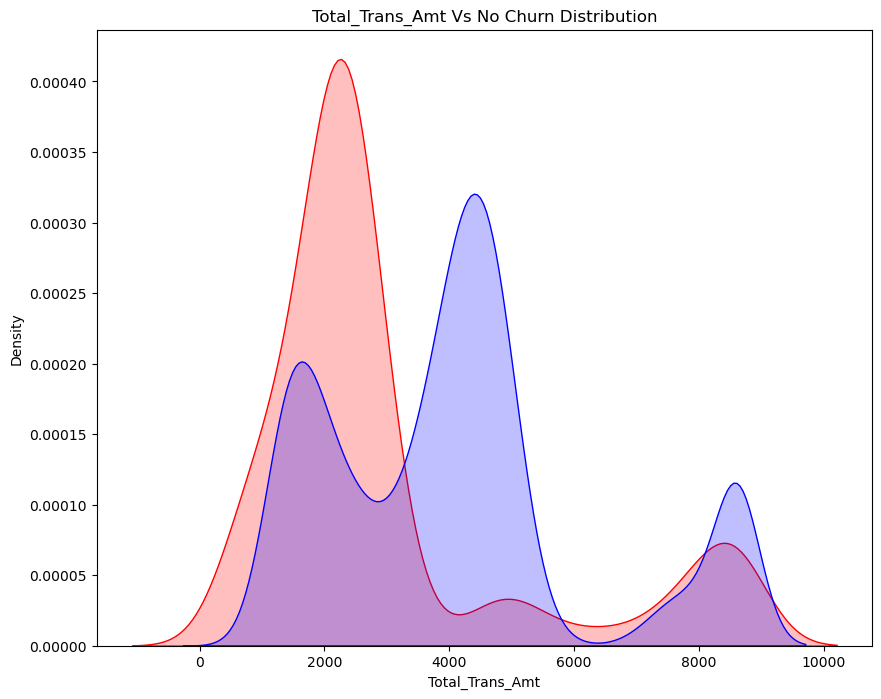

In [31]:
# Analyzing Total Transaction Amount Vs Churn Rate
plt.figure(figsize=(10,8))
sns.kdeplot(data=bank_churn[bank_churn["Attrition_Flag"] == 1], x ="Total_Trans_Amt",label="Churn",shade=True,color="red")
sns.kdeplot(data=bank_churn[bank_churn["Attrition_Flag"] == 0], x="Total_Trans_Amt",label="No Churn", shade=True,color="blue")
plt.title("Total_Trans_Amt Vs No Churn Distribution")
plt.xlabel("Total_Trans_Amt")
plt.ylabel("Density")
plt.show()

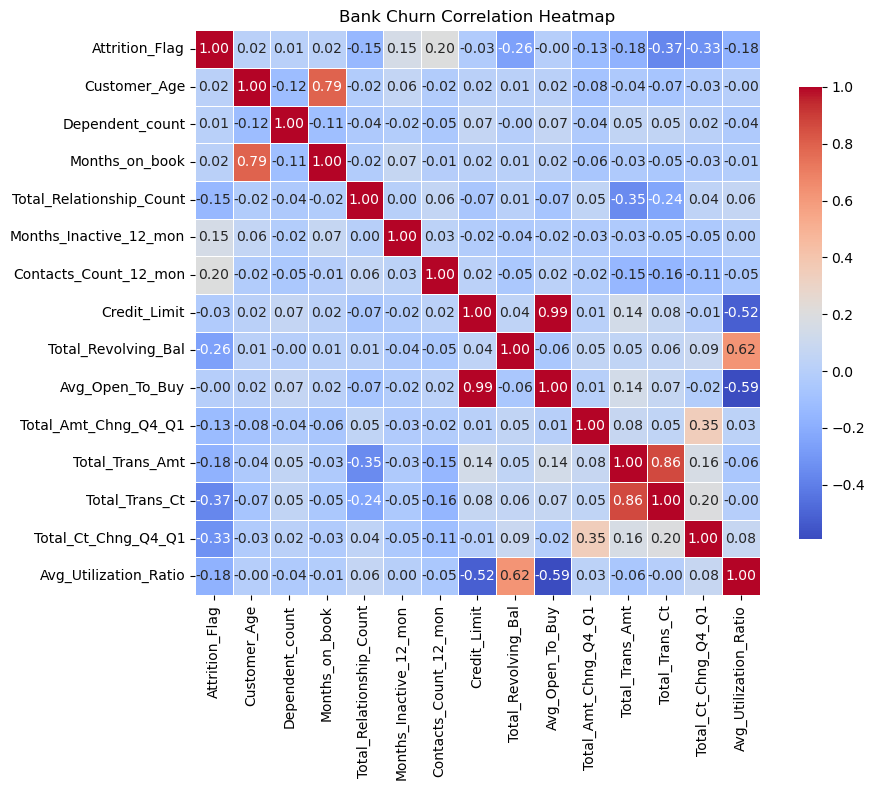

In [32]:
# Plotting a Correlation HeatMap

# Compute the Correlation Matrix
corr_matrix = bank_churn.corr(numeric_only=True)

plt.figure(figsize=(10,8))

# Plot the heatmap
sns.heatmap(corr_matrix,
            annot = True,
            fmt = ".2f",
            cmap = "coolwarm",
            linewidth = 0.5,
            square = True,
            cbar_kws = {"shrink":0.8})

plt.title("Bank Churn Correlation Heatmap")
plt.tight_layout()
plt.show()

# One Hot Encoder

In [33]:
# Converting categorical features to numerical binary models
# so that their correlation with target variable can be analyzed
categorical_columns = bank_churn.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(bank_churn[categorical_columns])

one_hot_bank_churn = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

bank_churn_encoded = pd.concat([bank_churn, one_hot_bank_churn], axis=1)

bank_churn_encoded = bank_churn_encoded.drop(categorical_columns, axis=1)

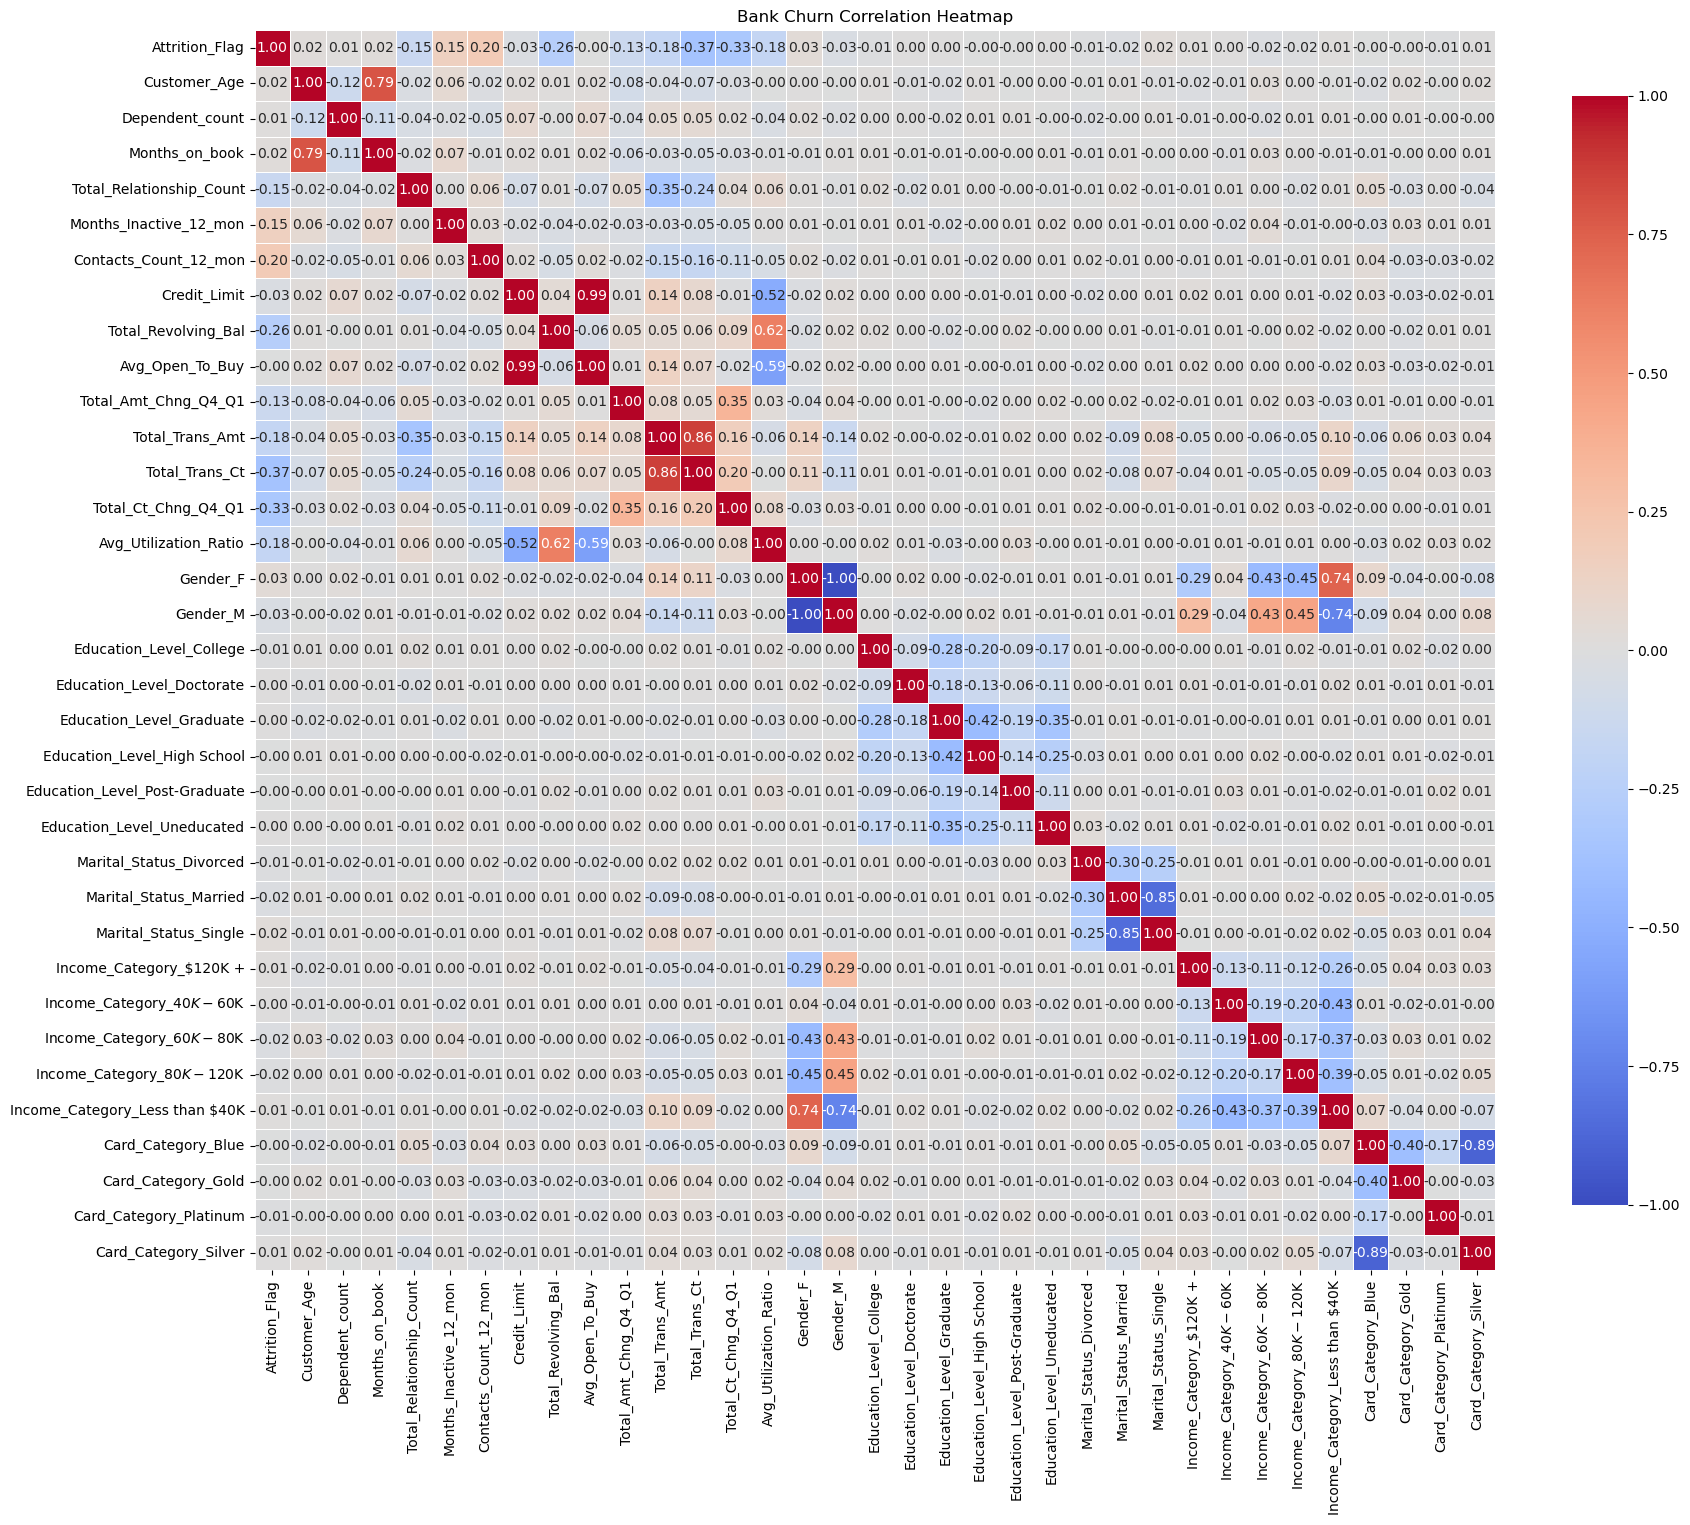

In [34]:
# Plotting a Correlation HeatMap

# Compute the Correlation Matrix
corr_matrix = bank_churn_encoded.corr(numeric_only=True)

plt.figure(figsize=(20,18))

# Plot the heatmap
sns.heatmap(corr_matrix,
            annot = True,
            fmt = ".2f",
            cmap = "coolwarm",
            linewidth = 0.5,
            square = True,
            cbar_kws = {"shrink":0.8})

plt.title("Bank Churn Correlation Heatmap")

plt.show()

- Education_Level,Card_Category,Income_Category and Marital Status have little to no correlation with the target variable
- Only Avg_Utilization_Ratio, Total_Ct_Chng_Q4_Q1, Total_Trans_Ct,Total_Trans_Amnt, Total_Amt_Chng_Q4_Q1, Total_Revolving_Bal, Months_inactive_12_mon,
Contacts_Count_12_mon and Total_Relationship_Count show show some correlation with the target variable

In [35]:
# Seperating target and features
#y = bank_churn['Attrition_Flag']  

# Drop target from features before encoding
#X = bank_churn.drop(columns=['Attrition_Flag'])

# Get categorical columns (excluding target)
#categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

# OneHotEncode categorical features
#encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
#one_hot_encoded = encoder.fit_transform(X[categorical_columns])

# Create dataframe and merge
#one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns), index=X.index)

# Drop original categorical columns and concatenate
#X_encoded = pd.concat([X.drop(columns=categorical_columns), one_hot_df], axis=1)

In [36]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7973 entries, 0 to 10126
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer_Age                    7973 non-null   int64  
 1   Dependent_count                 7973 non-null   int64  
 2   Months_on_book                  7973 non-null   int64  
 3   Total_Relationship_Count        7973 non-null   int64  
 4   Months_Inactive_12_mon          7973 non-null   int64  
 5   Contacts_Count_12_mon           7973 non-null   int64  
 6   Credit_Limit                    7973 non-null   float64
 7   Total_Revolving_Bal             7973 non-null   float64
 8   Avg_Open_To_Buy                 7973 non-null   float64
 9   Total_Amt_Chng_Q4_Q1            7973 non-null   float64
 10  Total_Trans_Amt                 7973 non-null   float64
 11  Total_Trans_Ct                  7973 non-null   float64
 12  Total_Ct_Chng_Q4_Q1             7973 n

# Train-Test Split
- Too many irrelevant features can cause the model to memorize noise instead of learning generalizable patterns.
- This can also affect the model's performance reducing accuracy, precision and recall
- So we train the model with fewer features that have better correlation with the target variable

In [71]:
X_features = ["Customer_Age","Avg_Utilization_Ratio","Total_Ct_Chng_Q4_Q1","Total_Trans_Ct","Total_Trans_Amt",
              "Total_Revolving_Bal","Months_Inactive_12_mon","Contacts_Count_12_mon","Total_Relationship_Count"]
             
X = bank_churn[X_features]

In [72]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,stratify=y)

# Pipeline Building ,Data Preprocessing,Model Training & Evaluation
- Standardize the numeric features by removing the mean and scaling to unit variance using StandardScaler()
- Fill in any missing values in the dataset (usually with the mean or median) using SimpleImputer()
- Apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes by creating synthetic samples of the minority class.
- Then train the model

In [73]:
Log_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression())
])

In [74]:
Log_pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('smote', SMOTE(random_state=42)),
                ('clf', LogisticRegression())])

In [75]:
log_pred = Log_pipe.predict(X_test)
log_proba = Log_pipe.predict_proba(X_test)[:, 1]
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_pred))
print("\nLogistic Regression Report:\n", classification_report(y_test, log_pred))

Logistic Regression Accuracy: 0.8476489028213167

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.97      0.84      0.90      1344
           1       0.51      0.87      0.64       251

    accuracy                           0.85      1595
   macro avg       0.74      0.86      0.77      1595
weighted avg       0.90      0.85      0.86      1595



In [76]:
Rand_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])
Rand_pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('model', RandomForestClassifier(random_state=42))])

In [77]:
Rand_pred = Rand_pipe.predict(X_test)
Rand_proba = Rand_pipe.predict_proba(X_test)[:, 1]
print("Random Forest Accuracy:", accuracy_score(y_test, Rand_pred))
print("\n Random Forest Report:\n", classification_report(y_test, Rand_pred))

Random Forest Accuracy: 0.9605015673981191

 Random Forest Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1344
           1       0.84      0.92      0.88       251

    accuracy                           0.96      1595
   macro avg       0.91      0.95      0.93      1595
weighted avg       0.96      0.96      0.96      1595



In [78]:
LightGBM_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf',LGBMClassifier(random_state=42))
])

In [79]:
LightGBM_pipe.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 5372, number of negative: 5372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 10744, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('clf', LGBMClassifier(random_state=42))])

In [80]:
LightGBM_pred = LightGBM_pipe.predict(X_test)
LightGBM_proba = LightGBM_pipe.predict_proba(X_test)[:, 1]
print("LGBM Classifier Accuracy:", accuracy_score(y_test, LightGBM_pred))
print("\n LGBM Classifier Report:\n", classification_report(y_test, LightGBM_pred))

LGBM Classifier Accuracy: 0.961128526645768

 LGBM Classifier Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1344
           1       0.84      0.92      0.88       251

    accuracy                           0.96      1595
   macro avg       0.91      0.95      0.93      1595
weighted avg       0.96      0.96      0.96      1595



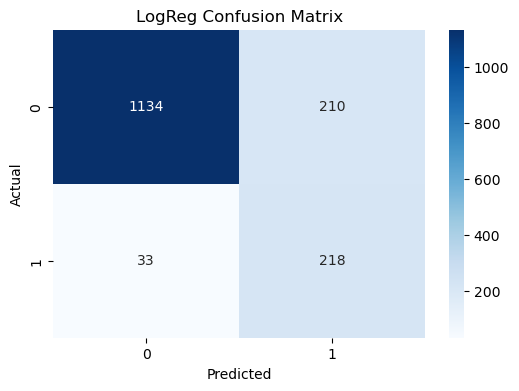

In [81]:
# Plot confusion matrix for Logistic Regression Model
conf_mat = confusion_matrix(y_test, log_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LogReg Confusion Matrix')
plt.show()

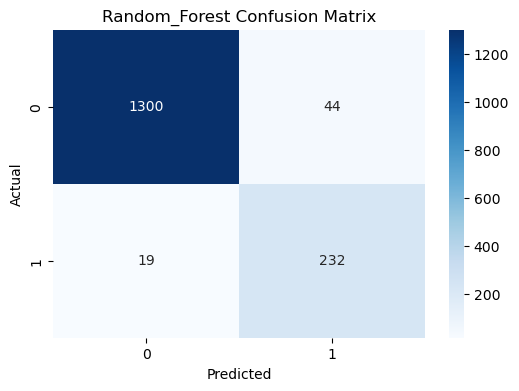

In [82]:
# Plot confusion matrix for Random Forest Model
conf_mat = confusion_matrix(y_test, Rand_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random_Forest Confusion Matrix')
plt.show()

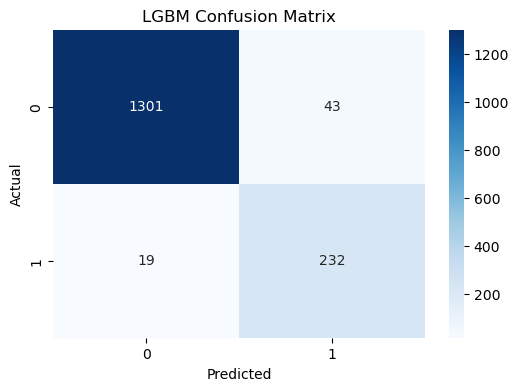

In [83]:
# Plot confusion matrix for LightGBM Classifier
conf_mat = confusion_matrix(y_test, LightGBM_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LGBM Confusion Matrix')
plt.show()

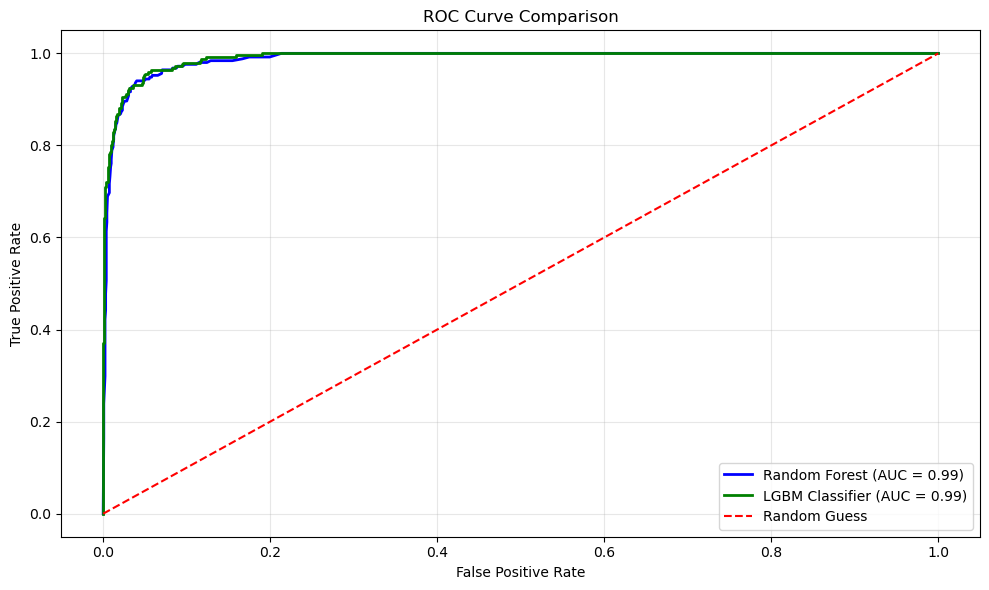

In [84]:
# --- ROC Curve & AUC ---
fpr_log, tpr_log, _ = roc_curve(y_test, Rand_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, LightGBM_proba)
auc_log = auc(fpr_log, tpr_log)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label=f'Random Forest (AUC = {auc_log:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'LGBM Classifier (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

- Both models have an AUC (Area Under Curve) of 0.99, indicating excellent classification performance.
- The curves are close to the top-left corner, meaning high true positive rates and low false positive rates.
- The red dashed line represents random guessing (AUC = 0.5), and both models perform far better than that.
- Both models are highly effective, with nearly perfect separation between the two classes

In [85]:
import joblib

# Assuming your pipeline is called 'pipe'
joblib.dump(LightGBM_pipe, 'lgbm_churn_model.pkl')


['lgbm_churn_model.pkl']

In [86]:
from IPython.display import FileLink

FileLink('lgbm_churn_model.pkl')

C:\Users\User\Desktop\DSA\lgbm_churn_model.pkl